In [1]:
import io, os, sys, types
from IPython import get_ipython
from nbformat import current
from IPython.core.interactiveshell import InteractiveShell

def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path

    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        if os.path.isfile(nb_path):
            return nb_path


class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path

    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)

        print ("importing Jupyter notebook from %s" % path)

        # load the notebook object
        with io.open(path, 'r', encoding='utf-8') as f:
            nb = current.read(f, 'json')


        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod

        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__

        try:
            for cell in nb.worksheets[0].cells:
                if cell.cell_type == 'code' and cell.language == 'python':
                    # transform the input to executable Python
                    code = self.shell.input_transformer_manager.transform_cell(cell.input)
                    # run the code in themodule
                    exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod


class NotebookFinder(object):
    """Module finder that locates Jupyter Notebooks"""
    def __init__(self):
        self.loaders = {}

    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return

        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)

        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]

sys.meta_path.append(NotebookFinder())

from load_dataset import *
from adversarial_debiasing_model import *
from fairness_metrics import *

/anaconda3/lib/python3.7/site-packages/nbformat/current.py:19: UserWarning: nbformat.current is deprecated.

- use nbformat for read/write/validate public API
- use nbformat.vX directly to composing notebooks of a particular version

  """)


importing Jupyter notebook from load_dataset.ipynb
importing Jupyter notebook from adversarial_debiasing_model.ipynb
importing Jupyter notebook from fairness_metrics.ipynb


In [2]:
###### compas dataset
filepath = "../../data/Compas Dataset/processed_compas.csv"
label, protect = "is_recid", "race_African-American"

balanced = {"label_only":True,"downsample":True}
num_proxy_to_remove = 0
train_dataset, test_dataset = train_test_dataset(filepath, label, protect, 
                                                 is_scaled=True,
                                                 num_proxy_to_remove=num_proxy_to_remove,
                                                 balanced=balanced
                                                )


# Data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, shuffle=True, worker_init_fn=np.random.seed(1))
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, shuffle=False, worker_init_fn=np.random.seed(1))

train_features, train_labels, train_protect = train_loader.dataset.features, train_loader.dataset.label, train_loader.dataset.protect
test_features, test_labels, test_protect = test_loader.dataset.features, test_loader.dataset.label, test_loader.dataset.protect



loaded
scaled
[[1477 1736]
 [1078 2135]]  balanced is_recid race_African-American
balanced


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
epoch 0; iter: 0; batch classifier loss: 0.686575
epoch 1; iter: 0; batch classifier loss: 0.685691
epoch 2; iter: 0; batch classifier loss: 0.680936
epoch 3; iter: 0; batch classifier loss: 0.650488
epoch 4; iter: 0; batch classifier loss: 0.646870
epoch 5; iter: 0; batch classifier loss: 0.647045
epoch 6; iter: 0; batch classifier loss: 0.642570
epoch 7; iter: 0; batch classifier loss: 0.630618
epoch 8; iter: 0; batch classifier loss: 0.621527
epoch 9; iter: 0; batch classifier loss: 0.644020
epoch 10; iter: 0; batch classifier loss: 0.616064
epoch 11; iter: 0; batch classifier loss: 0.626088
epoch 12; iter: 0; batch classifier loss: 0.629445
epoch 13; iter: 0; batch classifier loss: 0.631070
epoch 14; iter: 0; batch classifier loss: 0.639709
epoch 15; iter: 0; batch classifier loss: 0.594149
epoch 16; iter: 0; batch classifier loss: 0.598540
epoch 17; iter: 0; batch classifier loss: 0.592634
epoch 18; i

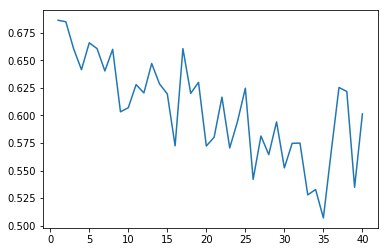

In [3]:
####### Hyperparameters
hyperparameters = {'adversary_loss_weight':0.1, 
                    'batch_size':64, 
                    'num_epochs':40, 
                    'learning_rate':0.001
                    }

def train_model(scope_name, hyperparameters, debias):
    with tf.Session(config=tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)) as sess:
        model = AdversarialLogisticModel(scope_name, sess, hyperparameters, seed=1, debias=debias)
        trained_model, epoch_losses = model.fit(train_features, train_labels, train_protect)
        train_pred_labels = trained_model.predict(train_features, train_labels, train_protect)
        test_pred_labels = trained_model.predict(test_features, test_labels, test_protect)
    return epoch_losses, train_pred_labels, test_pred_labels

epoch_losses, train_pred_labels, test_pred_labels = train_model("training", hyperparameters, False)
print("Train Accuracy: ", accuracy_score(train_labels, train_pred_labels))
print("Test Accuracy: ", accuracy_score(test_labels, test_pred_labels))
plt.plot(list(range(1, hyperparameters['num_epochs']+1)), epoch_losses)
plt.show()

In [5]:

black_confusion_matrix = binary_confusion_matrix(test_loader.dataset.label, test_pred_labels, test_loader.dataset.protect, 1)
white_confusion_matrix = binary_confusion_matrix(test_loader.dataset.label, test_pred_labels, test_loader.dataset.protect, 0)

black_fpr = false_positive_rate(black_confusion_matrix)
white_fpr = false_positive_rate(white_confusion_matrix)


black_fnr = false_negative_rate(black_confusion_matrix)
white_fnr = false_negative_rate(white_confusion_matrix)


print(black_confusion_matrix, " Blacks")
print(white_confusion_matrix, " Whites")

print(frac_predicted_positive(black_confusion_matrix), frac_predicted_positive(white_confusion_matrix), "Fraction predicted positive females, males")
print(statistical_parity_difference(black_confusion_matrix, white_confusion_matrix), " statistical_parity_difference")

print(black_fpr - white_fpr, "FPR difference")
print(black_fnr - white_fnr, "FNR difference")

print(true_positive_rate_difference(black_confusion_matrix, white_confusion_matrix), " true_positive_rate_difference")
print(false_positive_rate_difference(black_confusion_matrix, white_confusion_matrix), " false_positive_rate_difference")
print(average_odds_difference(black_confusion_matrix, white_confusion_matrix), " average_odds_difference")


[[319 138]
 [203 339]]  Blacks
[[292  57]
 [126 133]]  Whites
0.4774774774774775 0.3125 Fraction predicted positive females, males
0.16497747747747749  statistical_parity_difference
0.1386455831917388 FPR difference
-0.11194774109903266 FNR difference
0.11194774109903272  true_positive_rate_difference
0.1386455831917388  false_positive_rate_difference
0.12529666214538576  average_odds_difference
